In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)

In [2]:
df = pd.read_csv('sales_predictions.csv')
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


## Data Cleaning

In [3]:
df.shape

(8523, 12)

In [4]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [5]:
df.duplicated().any()

False

In [6]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [7]:
df[df.isna().any(axis=1)]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.20,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.20,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
...,...,...,...,...,...,...,...,...,...,...,...,...
8504,NCN18,NaN,Low Fat,0.124111,Household,111.7544,OUT027,1985,Medium,Tier 3,Supermarket Type3,4138.6128
8508,FDW31,11.35,Regular,0.043246,Fruits and Vegetables,199.4742,OUT045,2002,NaN,Tier 2,Supermarket Type1,2587.9646
8509,FDG45,8.10,Low Fat,0.214306,Fruits and Vegetables,213.9902,OUT010,1998,NaN,Tier 3,Grocery Store,424.7804
8514,FDA01,15.00,Regular,0.054489,Canned,57.5904,OUT045,2002,NaN,Tier 2,Supermarket Type1,468.7232


In [8]:
df = df.drop(columns = ['Item_Identifier', 'Outlet_Identifier'])
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


In [9]:
weight_average = df["Item_Weight"].mean()
df["Item_Weight"].fillna(value = weight_average, inplace=True)

In [10]:
df.isna().sum()

Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [11]:
df.dropna(inplace=True)
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.300,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.920,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.500,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
4,8.930,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052
5,10.395,Regular,0.000000,Baking Goods,51.4008,2009,Medium,Tier 3,Supermarket Type2,556.6088


In [12]:
df["Item_Type"].value_counts()

Fruits and Vegetables    883
Snack Foods              868
Household                649
Frozen Foods             615
Dairy                    496
Canned                   471
Baking Goods             463
Health and Hygiene       367
Soft Drinks              312
Meat                     309
Breads                   179
Hard Drinks              148
Others                   123
Starchy Foods            105
Breakfast                 79
Seafood                   46
Name: Item_Type, dtype: int64

In [13]:
df.replace(["LF"], ["Low Fat"], inplace=True)
df.replace(["low fat"], ["Low Fat"], inplace=True)
df.replace(["reg"], ["Regular"], inplace=True)
df["Item_Fat_Content"].value_counts()

Low Fat    3955
Regular    2158
Name: Item_Fat_Content, dtype: int64

In [14]:
df["Outlet_Size"].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

## Train Test Split

In [15]:
sklearn.__version__

'1.1.3'

In [16]:
## Make x and y variables
y = df['Item_Outlet_Sales'].copy()
X = df.drop(columns=['Item_Outlet_Sales']).copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
6785,5.325000,Regular,0.138680,Dairy,53.7298,1997,Small,Tier 1,Supermarket Type1
695,12.857645,Low Fat,0.032949,Household,116.8124,1985,Medium,Tier 3,Supermarket Type3
3964,14.000000,Low Fat,0.028981,Health and Hygiene,129.5310,2009,Medium,Tier 3,Supermarket Type2
2191,6.215000,Low Fat,0.012139,Fruits and Vegetables,39.2848,1987,High,Tier 3,Supermarket Type1
8081,8.300000,Regular,0.030274,Baking Goods,98.5384,2009,Medium,Tier 3,Supermarket Type2


In [17]:
## make categorical selector and verify it works 
cat_sel = make_column_selector(dtype_include='object')
cat_sel(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [18]:
## make numeric selector and verify it works 
num_sel = make_column_selector(dtype_include='number')
num_sel(X_train)

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [19]:
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

In [20]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),                                      
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13900ecd0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x138fe68e0>)],
                  verbose_feature_names_out=False)

In [21]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_Low Fat',
       'Item_Fat_Content_Regular', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household',
       'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood',
       'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Size_High',
       'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'], dtype=object)

In [22]:
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
6785,5.325000,0.138680,53.7298,1997.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
695,12.857645,0.032949,116.8124,1985.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3964,14.000000,0.028981,129.5310,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [23]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
6170,17.250,0.125224,41.2480,1997.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8421,10.895,0.064939,194.1794,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5998,15.750,0.054920,195.8452,2004.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [24]:
## confirm the first 3 rows index in y_test matches X_test_df
y_test.head(3)

6170     679.1160
8421    2340.9528
5998    4893.6300
Name: Item_Outlet_Sales, dtype: float64

## Linear Regression

In [25]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [26]:
## fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.56	RMSE= 1162.86
Test Data:	R^2= 0.56	RMSE= 1129.22


- Both the train and test data have an R2 value of 0.56, which is moderate, but not great. 

In [27]:
def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index = lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

In [28]:
coeffs = get_coefficients(lin_reg)
coeffs

Item_Weight                          -3.896122
Item_Visibility                    -327.124428
Item_MRP                             16.741567
Outlet_Establishment_Year            -2.262852
Item_Fat_Content_Low Fat            -15.185306
Item_Fat_Content_Regular             15.185306
Item_Type_Baking Goods               10.886959
Item_Type_Breads                     81.661813
Item_Type_Breakfast                 215.818327
Item_Type_Canned                    -44.585160
Item_Type_Dairy                     -31.710693
Item_Type_Frozen Foods              -22.898555
Item_Type_Fruits and Vegetables     -28.611384
Item_Type_Hard Drinks                 5.638167
Item_Type_Health and Hygiene         15.884867
Item_Type_Household                 -28.782828
Item_Type_Meat                       17.445528
Item_Type_Others                   -162.253560
Item_Type_Seafood                    45.138098
Item_Type_Snack Foods                23.073712
Item_Type_Soft Drinks               -87.118848
Item_Type_Sta

In [29]:
pd.set_option('display.float_format', lambda x: f"{x:,.4f}")
pd.set_option('display.max_rows', None)

In [30]:
coeffs.sort_values

<bound method Series.sort_values of Item_Weight                           -3.8961
Item_Visibility                     -327.1244
Item_MRP                              16.7416
Outlet_Establishment_Year             -2.2629
Item_Fat_Content_Low Fat             -15.1853
Item_Fat_Content_Regular              15.1853
Item_Type_Baking Goods                10.8870
Item_Type_Breads                      81.6618
Item_Type_Breakfast                  215.8183
Item_Type_Canned                     -44.5852
Item_Type_Dairy                      -31.7107
Item_Type_Frozen Foods               -22.8986
Item_Type_Fruits and Vegetables      -28.6114
Item_Type_Hard Drinks                  5.6382
Item_Type_Health and Hygiene          15.8849
Item_Type_Household                  -28.7828
Item_Type_Meat                        17.4455
Item_Type_Others                    -162.2536
Item_Type_Seafood                     45.1381
Item_Type_Snack Foods                 23.0737
Item_Type_Soft Drinks                -87.118

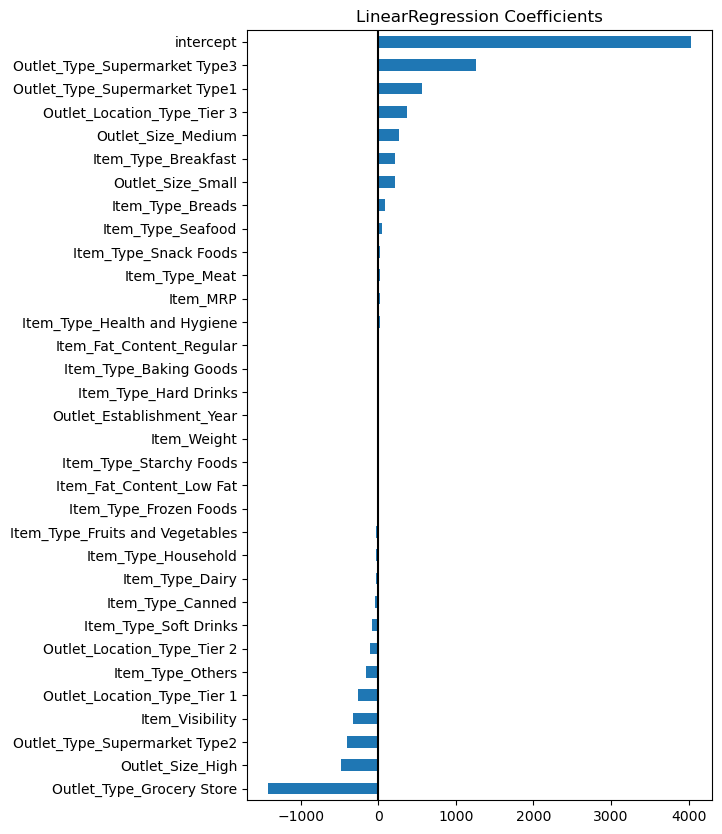

In [31]:
## Plot the coefficients
ax = coeffs.sort_values().plot(kind='barh',figsize=(6,10))
ax.axvline(0,color='k')
ax.set_title('LinearRegression Coefficients');

In [32]:
## fitting a linear regression model without the intercept
lin_reg = LinearRegression(fit_intercept = False)
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.56	RMSE= 1162.86
Test Data:	R^2= 0.56	RMSE= 1129.22


In [33]:
coeffs = get_coefficients(lin_reg)
coeffs

Item_Weight                           -3.8961
Item_Visibility                     -327.1244
Item_MRP                              16.7416
Outlet_Establishment_Year             -0.2415
Item_Fat_Content_Low Fat             -14.9358
Item_Fat_Content_Regular              15.4348
Item_Type_Baking Goods                10.9181
Item_Type_Breads                      81.6930
Item_Type_Breakfast                  215.8495
Item_Type_Canned                     -44.5540
Item_Type_Dairy                      -31.6795
Item_Type_Frozen Foods               -22.8674
Item_Type_Fruits and Vegetables      -28.5802
Item_Type_Hard Drinks                  5.6694
Item_Type_Health and Hygiene          15.9161
Item_Type_Household                  -28.7516
Item_Type_Meat                        17.4767
Item_Type_Others                    -162.2224
Item_Type_Seafood                     45.1693
Item_Type_Snack Foods                 23.1049
Item_Type_Soft Drinks                -87.0877
Item_Type_Starchy Foods           

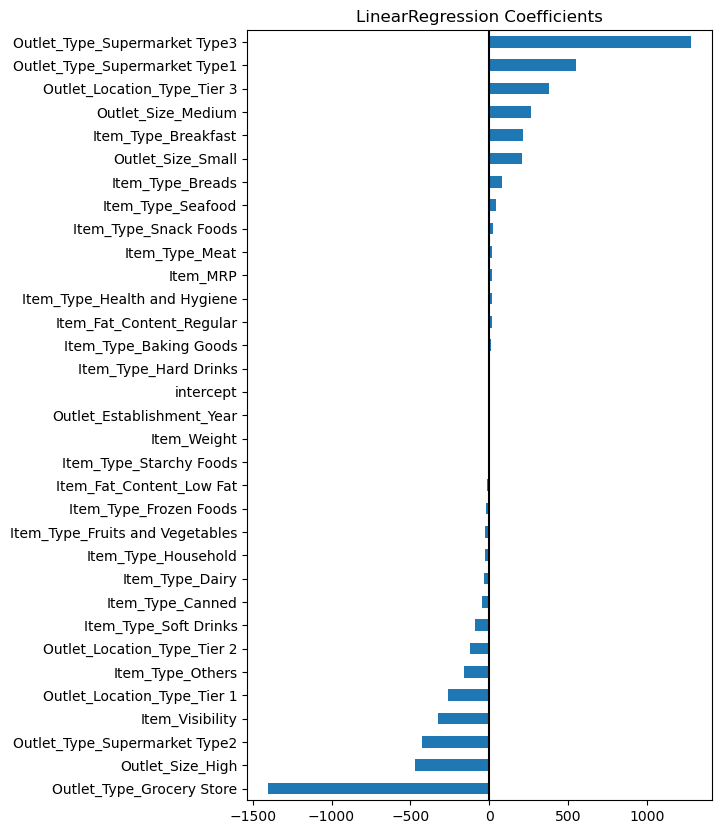

In [34]:
## Plot the coefficients
ax = coeffs.sort_values().plot(kind='barh',figsize=(6,10))
ax.axvline(0,color='k')
ax.set_title('LinearRegression Coefficients');

In [35]:
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
coeff_rank

Outlet_Type_Grocery Store         33.0000
Outlet_Type_Supermarket Type3     32.0000
Outlet_Type_Supermarket Type1     31.0000
Outlet_Size_High                  30.0000
Outlet_Type_Supermarket Type2     29.0000
Outlet_Location_Type_Tier 3       28.0000
Item_Visibility                   27.0000
Outlet_Size_Medium                26.0000
Outlet_Location_Type_Tier 1       25.0000
Item_Type_Breakfast               24.0000
Outlet_Size_Small                 23.0000
Item_Type_Others                  22.0000
Outlet_Location_Type_Tier 2       21.0000
Item_Type_Soft Drinks             20.0000
Item_Type_Breads                  19.0000
Item_Type_Seafood                 18.0000
Item_Type_Canned                  17.0000
Item_Type_Dairy                   16.0000
Item_Type_Household               15.0000
Item_Type_Fruits and Vegetables   14.0000
Item_Type_Snack Foods             13.0000
Item_Type_Frozen Foods            12.0000
Item_Type_Meat                    11.0000
Item_MRP                          

In [36]:
top_n_features = coeff_rank.head(10)
top_n_features

Outlet_Type_Grocery Store       33.0000
Outlet_Type_Supermarket Type3   32.0000
Outlet_Type_Supermarket Type1   31.0000
Outlet_Size_High                30.0000
Outlet_Type_Supermarket Type2   29.0000
Outlet_Location_Type_Tier 3     28.0000
Item_Visibility                 27.0000
Outlet_Size_Medium              26.0000
Outlet_Location_Type_Tier 1     25.0000
Item_Type_Breakfast             24.0000
dtype: float64

In [37]:
## Slicing out the top_n_features names to visualize
plot_vals = coeffs.loc[top_n_features.index]
plot_vals

Outlet_Type_Grocery Store       -1,401.5662
Outlet_Type_Supermarket Type3    1,279.4805
Outlet_Type_Supermarket Type1      551.1293
Outlet_Size_High                  -470.5836
Outlet_Type_Supermarket Type2     -428.5446
Outlet_Location_Type_Tier 3        380.3523
Item_Visibility                   -327.1244
Outlet_Size_Medium                 262.0511
Outlet_Location_Type_Tier 1       -258.8267
Item_Type_Breakfast                215.8495
dtype: float64

In [38]:
top_n = 3
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n).index
plot_vals = coeffs.loc[top_n_features].sort_values()
plot_vals

Outlet_Type_Grocery Store       -1,401.5662
Outlet_Type_Supermarket Type1      551.1293
Outlet_Type_Supermarket Type3    1,279.4805
dtype: float64

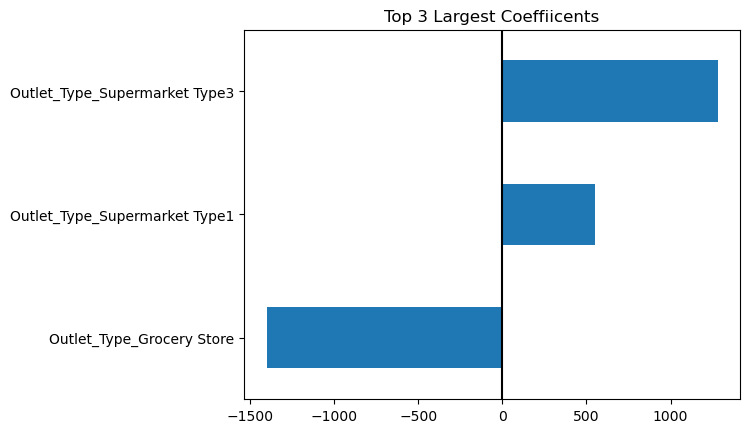

In [42]:
## Plot the coefficients
ax = plot_vals.sort_values().plot(kind='barh')#,figsize=(5,6))
ax.axvline(0,color='k')
ax.set_title(f'Top {top_n} Largest Coeffiicents');
plt.savefig('lin_reg_coefficients.png')

- The top 3 largest coefficients were all outlet types- supermarket type 1, type 3, and grocery stores. 
- These had the most impact on the model predictions. Type 3 and Type 1 had a positive correlation with outlet sales, while grocery stores had a negative correlation wit outlet sales.

## Random Forest

In [47]:
reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 447.00
Test Data:	R^2= 0.52	RMSE= 1170.07


- The training data does very well with an R2 score of 0.94, but the test data does much worse, with an R2 score of only 0.52

In [48]:
reg.feature_importances_

array([0.05349934, 0.10367479, 0.47565201, 0.0456104 , 0.00602976,
       0.00552592, 0.0056426 , 0.0035251 , 0.0026435 , 0.00475971,
       0.00641266, 0.00621704, 0.00943378, 0.00282498, 0.00498407,
       0.00686899, 0.00416183, 0.00203221, 0.00149057, 0.00848773,
       0.00458302, 0.00258815, 0.0024605 , 0.004045  , 0.00516753,
       0.00494109, 0.00378269, 0.0041338 , 0.11639133, 0.00243668,
       0.00215439, 0.08783883])

In [49]:
## Checking the number of feature importances matches the # of columns
print(len(reg.feature_importances_))
print(len(X_train_df.columns))
len(reg.feature_importances_) == len(X_train_df.columns)

32
32


True

In [50]:
## Saving the feature importances
importances = pd.Series(reg.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances

Item_Weight                       0.0535
Item_Visibility                   0.1037
Item_MRP                          0.4757
Outlet_Establishment_Year         0.0456
Item_Fat_Content_Low Fat          0.0060
Item_Fat_Content_Regular          0.0055
Item_Type_Baking Goods            0.0056
Item_Type_Breads                  0.0035
Item_Type_Breakfast               0.0026
Item_Type_Canned                  0.0048
Item_Type_Dairy                   0.0064
Item_Type_Frozen Foods            0.0062
Item_Type_Fruits and Vegetables   0.0094
Item_Type_Hard Drinks             0.0028
Item_Type_Health and Hygiene      0.0050
Item_Type_Household               0.0069
Item_Type_Meat                    0.0042
Item_Type_Others                  0.0020
Item_Type_Seafood                 0.0015
Item_Type_Snack Foods             0.0085
Item_Type_Soft Drinks             0.0046
Item_Type_Starchy Foods           0.0026
Outlet_Size_High                  0.0025
Outlet_Size_Medium                0.0040
Outlet_Size_Smal

In [59]:
## Saving the feature importances sorted from largest to smallest (ascending=False)
sorted_importance = importances.sort_values(ascending=False)
sorted_importance

Item_MRP                          0.4757
Outlet_Type_Grocery Store         0.1164
Item_Visibility                   0.1037
Outlet_Type_Supermarket Type3     0.0878
Item_Weight                       0.0535
Outlet_Establishment_Year         0.0456
Item_Type_Fruits and Vegetables   0.0094
Item_Type_Snack Foods             0.0085
Item_Type_Household               0.0069
Item_Type_Dairy                   0.0064
Item_Type_Frozen Foods            0.0062
Item_Fat_Content_Low Fat          0.0060
Item_Type_Baking Goods            0.0056
Item_Fat_Content_Regular          0.0055
Outlet_Size_Small                 0.0052
Item_Type_Health and Hygiene      0.0050
Outlet_Location_Type_Tier 1       0.0049
Item_Type_Canned                  0.0048
Item_Type_Soft Drinks             0.0046
Item_Type_Meat                    0.0042
Outlet_Location_Type_Tier 3       0.0041
Outlet_Size_Medium                0.0040
Outlet_Location_Type_Tier 2       0.0038
Item_Type_Breads                  0.0035
Item_Type_Hard D

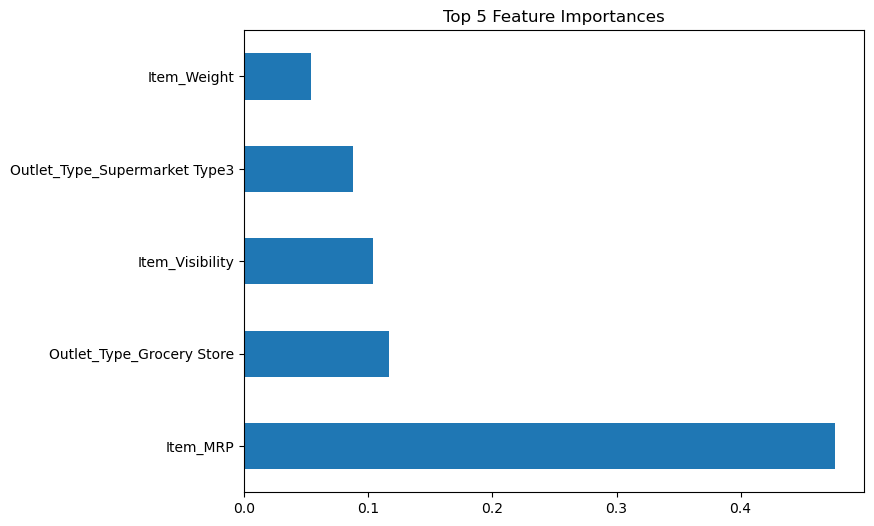

In [60]:
## just keep the top 10 importances and plot
sorted_importance.head(5).plot(kind='barh',
                                   figsize=(8,6)).set(title = 'Top 5 Feature Importances')
plt.savefig('rf_importances.png')

In [65]:
## Drop the least important columns
drop_cols = ['Item_Type_Seafood','Item_Type_Others', 'Outlet_Type_Supermarket Type2',
            'Outlet_Type_Supermarket Type1', 'Outlet_Size_High']
X_train_B = X_train_df.drop(columns=drop_cols)
X_test_B = X_test_df.drop(columns=drop_cols)
feature_names_B = X_train_B.columns
X_train_B.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type3
6785,5.3250,0.1387,53.7298,"1,997.0000",0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000
695,12.8576,0.0329,116.8124,"1,985.0000",1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000
3964,14.0000,0.0290,129.5310,"2,009.0000",1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


In [66]:
reg_B = RandomForestRegressor(random_state = SEED)
reg_B.fit(X_train_B, y_train)
evaluate_regression(reg_B, X_train_B, y_train, X_test_B,y_test)

Training Data:	R^2= 0.94	RMSE= 447.07
Test Data:	R^2= 0.53	RMSE= 1168.09


- The test data R2 slightly improved here. 

## Saving Best Models

In [67]:
## saving variables for next lesson/notebook
import joblib
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_B,
         'y_train': y_train,
         'X_test':X_test_B,
          "y_test": y_test,
         'preprocessor':preprocessor,
          'LinearRegression': lin_reg, 
         'RandomForest':reg_B}
joblib.dump(export, 'best-models.joblib')

['best-models.joblib']